## Welcome to my EDA Kernel

### Description:
The dataset for this competition includes aggregate stopped vehicle information and intersection wait times. Your task is to predict congestion, based on an aggregate measure of stopping distance and waiting times, at intersections in 4 major US cities: Atlanta, Boston, Chicago & Philadelphia.

<img src="https://cdn.citylab.com/media/img/citylab/2018/02/AP_17153592466989/facebook.jpg" alt="Italian Trulli">


# Objective:
It's a first contact with the data, so I want to explore it and understand how the data is. 

Some important things that is standard to analyze:
- what are the data types of the features?
- We have missing values?
- How many unique values we have in each feature;
- The shape of full dataset.
- The entropy of each feature (that show us the level of disorder on this column, it's like a "messy metric")

After this first analyze we can think in other questions to explore:
- Which distribution we have in our columns? 
- Which are the most common cities?
- Which are the distribution of the stops, time, distances?
- How long is our date range? 
- What are the distribution of the regions?

And many more questions;

## <font color="red"> I'm near of grandmaster tier, so, if you find this kernel useful or interesting, please don't forget to upvote the kernel =)</font>

### Importing the Main Libraries to work with data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.横坐标是hour，纵是平均堵车时间的图
#热力图
#地图上的堵车

### Importing datasets

In [2]:
df_train = pd.read_csv('C:/Users/Lorrine/Desktop/bia656/project/crossroad.csv')
df_test = pd.read_csv('C:/Users/Lorrine/Desktop/bia656/project/test.csv')

### Util functions 

In [3]:
sns.set(style='ticks', palette='Set2')
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


### Summary of the data

In [4]:
resumetable(df_train)
df_train.describe()

Dataset Shape: (857409, 28)


RowId  IntersectionId       Latitude      Longitude  \
count  8.574090e+05   857409.000000  857409.000000  857409.000000   
mean   2.349039e+06      836.330832      39.657555     -77.900396   
std    2.475128e+05      644.200553       2.920760       5.975814   
min    1.920335e+06        0.000000      33.649970     -87.836750   
25%    2.134687e+06      306.000000      39.937600     -84.387710   
50%    2.349039e+06      685.000000      39.985810     -75.173270   
75%    2.563391e+06     1254.000000      41.918580     -75.080190   
max    2.777743e+06     2875.000000      42.381780     -71.023520   

                Hour        Weekend          Month  TotalTimeStopped_p20  \
count  857409.000000  857409.000000  857409.000000         857409.000000   
mean       12.427463       0.277485       9.104448              1.731272   
std         6.062097       0.447758       1.993233              7.080017   
min         0.000000       0.000000       1.000000              0.000000   
25%         8.000000       0.000000       7.000000              0.000000   
50%        13.000000       0.000000       9.000000              0.000000   
75%        17.000000       1.000000      11.000000              0.000000   
max        23.000000       1.000000      12.000000            273.000000   

       TotalTimeStopped_p40  TotalTimeStopped_p50  ...  TimeFromFirstStop_p20  \
count         857409.000000         857409.000000  ...          857409.000000   
mean               5.356027              7.681874  ...               3.126932   
std               12.861420             15.553418  ...              11.631092   
min                0.000000              0.000000  ...               0.000000   
25%                0.000000              0.000000  ...               0.000000   
50%                0.000000              0.000000  ...               0.000000   
75%                0.000000             10.000000  ...               0.000000   
max              318.000000            343.000000  ...             334.000000   

       TimeFromFirstStop_p40  TimeFromFirstStop_p50  TimeFromFirstStop_p60  \
count          857409.000000          857409.000000          857409.000000   
mean                9.051338              12.613628              18.801785   
std                20.120829              23.847749              29.399634   
min                 0.000000               0.000000               0.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               0.000000               0.000000   
75%                 0.000000              22.000000              31.000000   
max               347.000000             355.000000             358.000000   

       TimeFromFirstStop_p80  DistanceToFirstStop_p20  \
count          857409.000000            857409.000000   
mean               34.037097                 6.564450   
std                40.619387                28.003261   
min                 0.000000                 0.000000   
25%                 0.000000                 0.000000   
50%                27.000000                 0.000000   
75%                49.000000                 0.000000   
max               359.000000              1902.700000   

       DistanceToFirstStop_p40  DistanceToFirstStop_p50  \
count            857409.000000            857409.000000   
mean                 19.872987                28.255852   
std                  56.564229                71.720090   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                52.900000   
max                3099.500000              3099.500000   

       DistanceToFirstStop_p60  DistanceToFirstStop_p80  
count            857409.000000            857409.000000  
mean                 43.273503                81.922639  
std                  96.933561               152.68276

Nice, this func give us a lot of cool and useful informations;
- We have only two features with missing values. Entry and Exit StreetName

# City's
- I will start exploring the distribution of City's because it is a categorical with only a few categorys inside.


In [5]:
resumetable(df_train)

Dataset Shape: (857409, 28)


Name   dtypes  Missing  Uniques  \
0                     RowId    int64        0   857409   
1            IntersectionId    int64        0     2539   
2                  Latitude  float64        0     4505   
3                 Longitude  float64        0     4541   
4           EntryStreetName   object     8189     1707   
5            ExitStreetName   object     5534     1693   
6              EntryHeading   object        0        8   
7               ExitHeading   object        0        8   
8                      Hour    int64        0       24   
9                   Weekend    int64        0        2   
10                    Month    int64        0        9   
11                     Path   object        0    15111   
12     TotalTimeStopped_p20    int64        0      172   
13     TotalTimeStopped_p40    int64        0      234   
14     TotalTimeStopped_p50    int64        0      264   
15     TotalTimeStopped_p60    int64        0      311   
16     TotalTimeStopped_p80    int64        0      403   
17    TimeFromFirstStop_p20    int64        0      239   
18    TimeFromFirstStop_p40    int64        0      306   
19    TimeFromFirstStop_p50    int64        0      329   
20    TimeFromFirstStop_p60    int64        0      351   
21    TimeFromFirstStop_p80    int64        0      355   
22  DistanceToFirstStop_p20  float64        0     3479   
23  DistanceToFirstStop_p40  float64        0     6257   
24  DistanceToFirstStop_p50  float64        0     7483   
25  DistanceToFirstStop_p60  float64        0     9495   
26  DistanceToFirstStop_p80  float64        0    13267   
27                     City   object        0        4   

                                          First Value  \
0                                             1920335   
1                                                   0   
2                                             33.7917   
3                                              -84.43   
4                        Marietta Boulevard Northwest   
5                        Marietta Boulevard Northwest   
6                                                  NW   
7                                                  NW   
8                                                   0   
9                                                   0   
10                                                  6   
11  Marietta Boulevard Northwest_NW_Marietta Boule...   
12                                                  0   
13                                                  0   
14                                                  0   
15                                                  0   
16                                                  0   
17                                                  0   
18                                                  0   
19                                                  0   
20                                                  0   
21                                                  0   
22                                                  0   
23                                                  0   
24                                                  0   
25                                                  0   
26                                                  0   
27                                            Atlanta   

                                         Second Value  \
0                                             1920336   
1                                                   0   
2                                             33.7917   
3                                              -84.43   
4                        Marietta Boulevard Northwest   
5                        Marietta Boulevard Northwest   
6                                                  SE   
7                                                  SE   
8                                                   0   
9                                                   0   
10                                                  6   
11

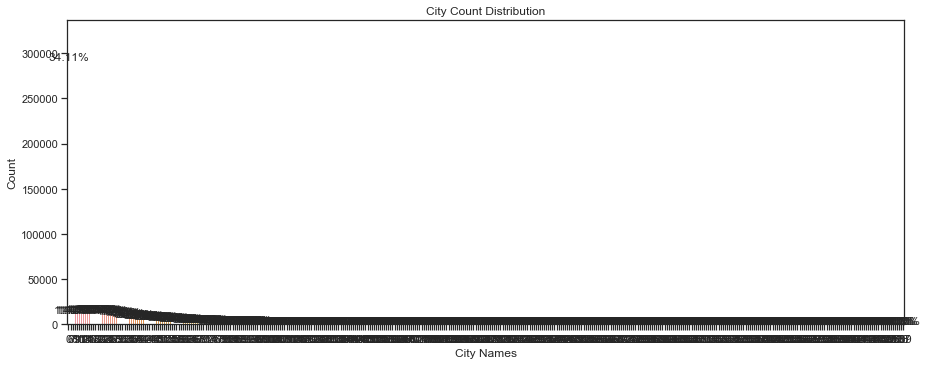

In [5]:
total = len(df_train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="TotalTimeStopped_p80", data=df_train)
g.set_title("City Count Distribution")
g.set_ylabel("Count")
g.set_xlabel("City Names")
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

We can note that:
- The most common value is Philadelphia and it have 45.29% of the total entries.
- The other categories don't have a so discrepant difference between them. 
?
Let's 


# Date Features
- Hour Distribution
- Month Distribution


In [11]:
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

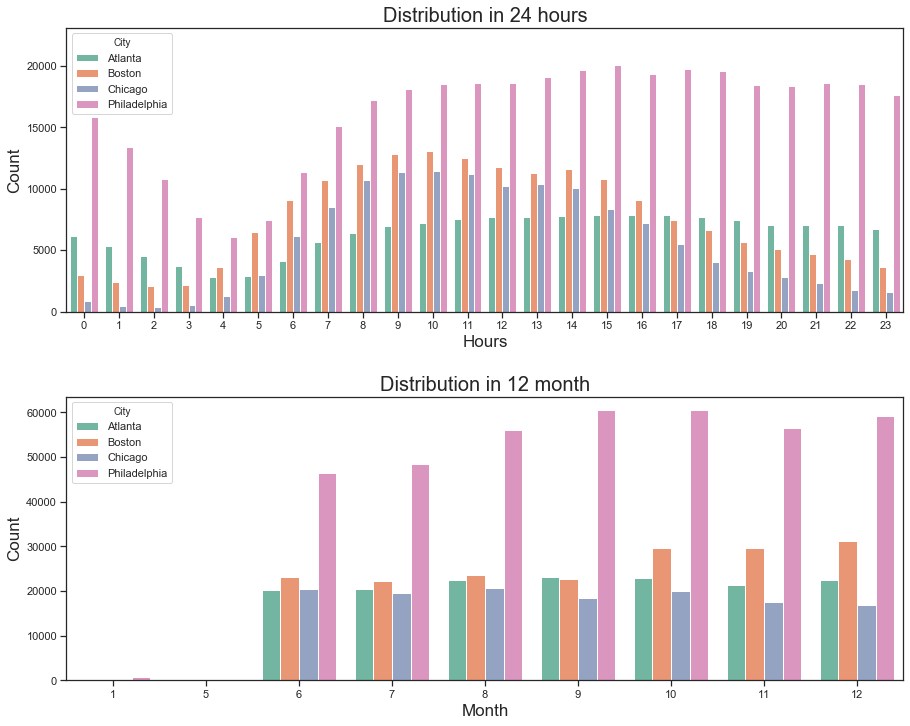

In [14]:
plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue='City', dodge=True)
g.set_title("Distribution in 24 hours", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue='City', dodge=True)
g1.set_title("Distribution in 12 month", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Month", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

plt.subplots_adjust(hspace = 0.3)

plt.show()
#记录中每个城市的每小时的数据记录量

Cool. <br>

In the hours chart:
- We can see that cities can have different hours patterns.
- Philadelphia is by far the most common in all hours. Only on 5 a.m that is almost lose to Boston in total entries.
- Atlanta is the city with less entries in all day, but after 17 p.m to 4a.m it's the second city with more rides 

In the month chart:
- We can note that the data is about only 6 months (with few values in January and May)
- Also, the pattern of the Boston City improved througout the time and the others seem very unchanged. 

Now, let's explore the Entry and Exit features.


# EntryHeading and Exit Heading

In [104]:
plt.figure(figsize=(15,12))

tmp = round(((df_train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=df_train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)
gt = g.twinx()
gt = sns.pointplot(x='EntryHeading', y='RowId', 
                   data=tmp, order=list(tmp['EntryHeading'].values),
                   color='black', legend=False)
gt.set_ylim(0, tmp['RowId'].max()*1.1)
gt.set_ylabel("% of Total(Black Line)", fontsize=16)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=list(tmp['EntryHeading'].values), 
                   data=df_train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

Nice. <br>
In Entry and Exit Heading chart:
- We can note that in general the Entry and Exit Region is exactly the same. 

In Entry by Cities chart:
- We can note the difference patterns on the cities. It's a very interesting and could give us many interesting insights. 

## IntersectionID 

In [9]:
plt.figure(figsize=(15,6))
df_train.TotalTimeStopped_p20.value_counts()[:20].plot(kind='bar')
plt.xlabel("IntersectionID", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Most commmon IntersectionID's ", fontsize=22)

plt.show()

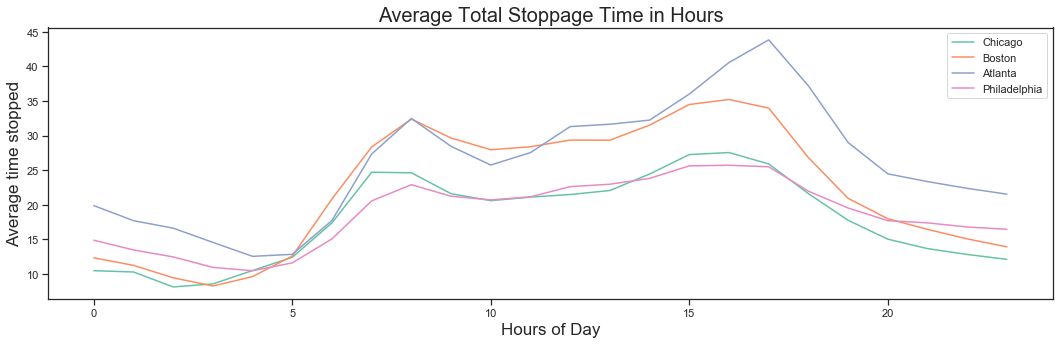

In [99]:
plt.figure(figsize=(18,5))

plt.plot(df_train[df_train['City']=='Chicago'].groupby('Hour')['TotalTimeStopped_p80'].mean(),label="Chicago")
plt.plot(df_train[df_train['City']=='Boston'].groupby('Hour')['TotalTimeStopped_p80'].mean(),label="Boston")
plt.plot(df_train[df_train['City']=='Atlanta'].groupby('Hour')['TotalTimeStopped_p80'].mean(),label="Atlanta")
plt.plot(df_train[df_train['City']=='Philadelphia'].groupby('Hour')['TotalTimeStopped_p80'].mean(),label="Philadelphia")
plt.title("Average Total Stoppage Time in Hours", fontsize=20)
plt.ylabel("Average time stopped",fontsize= 17)
plt.xlabel("Hours of Day", fontsize=17)
plt.legend()
sizes=[]

plt.show()

# Exploring numerical features
If you readed the competition description, you know that these are the target features;

The targets are: 
- TotalTimeStopped_p20
- TotalTimeStopped_p50
- TotalTimeStopped_p80
- DistanceToFirstStop_p20
- DistanceToFirstStop_p50
- DistanceToFirstStop_p80

And the as the TimeFromFirstStop is an optional data, I will use it to see the correlations.


In [31]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50', 
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

# Heatmap Target Features

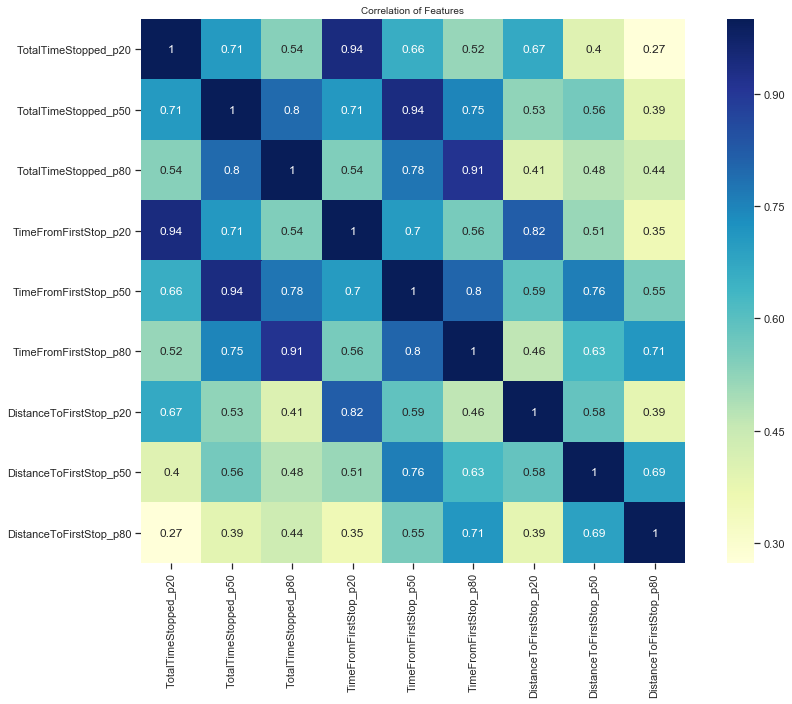

In [34]:
plt.figure(figsize=(15,10))
plt.title('Correlation of Features', fontsize=10)
sns.heatmap(df_train[t_stopped + t_first_stopped + d_first_stopped].astype(float).corr(),cmap="YlGnBu",
            vmax=1.0, square=True,annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

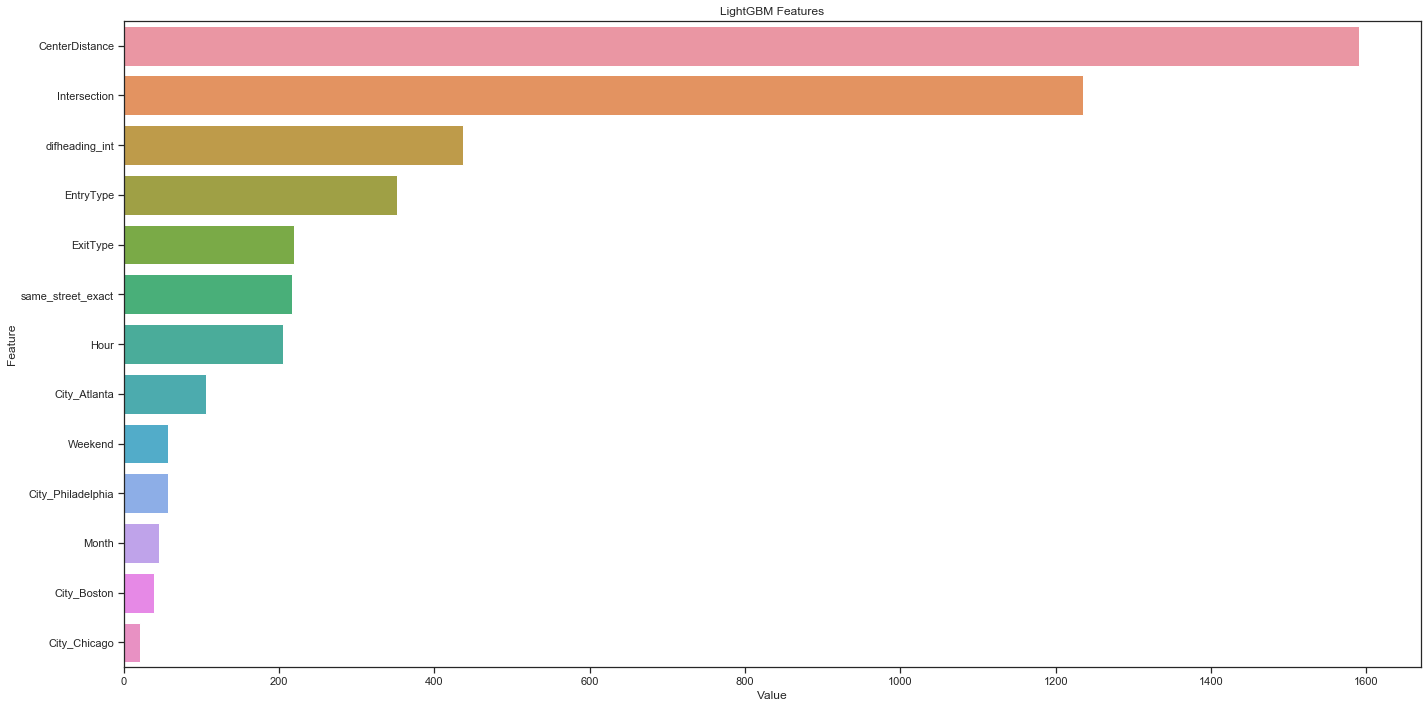

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),x.columns)), columns=['Value','Feature'])
fea_imp = {'Feature':['Hour', 'Weekend', 'Month',
             'same_street_exact', 'EntryType',
                'ExitType', 'difheading_int','CenterDistance',
                'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                'City_Atlanta','Intersection'], 'Value':[ 205,   57,   45,  216,  352,  219,  437, 1591,   39,   21,   57,
        106, 1235]} 

fea_imp = pd.DataFrame(fea_imp) 
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=fea_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()